In [2]:
%matplotlib widget

from functools import partial

import numpy as np
from scipy.signal import find_peaks
from scipy import optimize
import matplotlib.pyplot as plt

from comp_inhib_wc import sim_dev, plot_sim_dev

In [3]:
def cost_func(neg_dev_peak, pos_dev_peak, std_peak):
    # kinda works but doesn't officially converge
    # return (std_peak - (neg_dev_peak + pos_dev_peak) / 2) / np.abs(neg_dev_peak - pos_dev_peak)
    # most effective!!
    neg_dev_diff = neg_dev_peak - std_peak
    pos_dev_diff = pos_dev_peak - std_peak
    if neg_dev_diff < 0 and pos_dev_diff < 0:
        # discourage the case where both pos and neg deviants produce
        # decreasing responses
        return neg_dev_diff * pos_dev_diff
    else:
        # optimizer will spend most of its time here trying to minimize
        return -neg_dev_diff * pos_dev_diff
    # kinda works with Nelder-Mead, but doesn't officially converge
    # return std_peak - np.min([neg_dev_peak, pos_dev_peak])


def cost_func_02(neg_dev_peak, pos_dev_peak, std_peak):
    neg_dev_diff = neg_dev_peak - std_peak
    pos_dev_diff = pos_dev_peak - std_peak
    return np.log(neg_dev_diff ** 2) + np.log(pos_dev_diff ** 2)


def get_final_response_peak(x, times, t_win, n_dim_units=2):
    t_idxs = np.nonzero(np.logical_and(times >= t_win[0], times < t_win[1]))[0]
    x_avg = np.mean(x[t_idxs, :n_dim_units], axis=1)
    peak = np.max(x_avg)
    return peak


def validate_responses(x, inj_excite):
    """Test that none of the units enter the high attractor basin."""
    # NB: only one unit's inj_excite is needed since the rise and drop times
    # are the same across units
    inj_traj = inj_excite[:, 0]
    di = np.diff(inj_traj, axis=0)
    # compensate for sample lost during diff calculation
    drop_idxs = np.nonzero(di < 0)[0] + 1
    rise_idxs = np.nonzero(di > 0)[0] + 1
    drop_win_length = rise_idxs[1] - drop_idxs[0]

    runaway_excite = False
    for drop_idx in drop_idxs:
        x_drop = x[drop_idx, :]
        x_post_drop = x[drop_idx:drop_idx + drop_win_length, :]
        print(drop_idx, drop_idx + drop_win_length)
        runaway_excite = bool(np.sum((x_post_drop - x_drop) > 0))
        if runaway_excite:
            return False
    return True


def sim_and_eval_cost(params_vary, plot_sims=False, plot_sims_wo_fb=False):
    """Call this function for minimization."""
    # const params
    dev_mag = 0.2
    tau = 20
    tau_2 = 20
    thresh = 0.5
    thresh_2 = 0.5
    steepness = 8
    steepness_2 = 15
    ipsirepr_inhib = 0.75
    rep_interval = 100
    # super const params (these are hardcoded in sim_dev but relevant here)
    n_dim_units = 2
    burn_in = 100

    # varied params
    w_ii, w_ij, w_ii_l2, w_ij_l2, w_fb = params_vary

    if plot_sims is True:
        gridspec = {'width_ratios': [1, 1, 1], 'height_ratios': [3, 1]}
        fig, axes = plt.subplots(2, 3, sharex='col', sharey='row',
                                 gridspec_kw=gridspec, figsize=(6, 4))
        if plot_sims_wo_fb is True:
            # plot without cross-group inhibition
            w_fb = 0.0

    # run 3 sims: neg dev, pos dev, and no dev for control
    peaks = list()
    for idx, dev_sign in enumerate([-1, 0, 1]):
        dev = dev_sign * dev_mag
        # dev = dev_sign
        times, x, inj_excite, _w = sim_dev(dev=dev,
                                           w_ii=w_ii,
                                           w_ij=w_ij,
                                           w_ii_l2=w_ii_l2,
                                           w_ij_l2=w_ij_l2,
                                           w_fb=w_fb,
                                           tau=tau,
                                           tau_2=tau_2,
                                           thresh=thresh,
                                           thresh_2=thresh_2,
                                           steepness=steepness,
                                           steepness_2=steepness_2,
                                           ipsirepr_inhib=ipsirepr_inhib,
                                           rep_interval=rep_interval)
        
        tstop = times[-1]
        final_t_win = [tstop - rep_interval, tstop]
        final_peak = get_final_response_peak(x, times, final_t_win,
                                             n_dim_units=n_dim_units)
        peaks.append(final_peak)

        # valid_trial = validate_responses(x, inj_excite)
        # if not valid_trial:
        #     print('Warning: simulated an invalid trail with runaway '
        #           'excitation!!!')

        if plot_sims is True:
            # shift time values to reflect burn_in/baseline
            times -= burn_in
            plot_sim_dev(times, x[:, :], axes[0, idx])
            colors = ['tab:red', 'tab:blue', 'tab:green']
            for unit_idx in range(inj_excite.shape[1] // 2):
                inj_excite_traj = inj_excite[:, unit_idx]
                axes[1, idx].plot(times, inj_excite_traj,
                                  color=colors[unit_idx])
                axes[1, idx].set_xticks(np.arange(0, tstop - burn_in + 1,
                                                  rep_interval))
    
    if plot_sims is True:
        return fig

    return cost_func(peaks[0], peaks[2], peaks[1])

In [4]:
# set initial param values + bounds that will get varied during optimization
x0 = [0.9, -0.9, 0.2, -0.4, -0.8]
bounds = [(0.1, 1.0),
          (-1.1, -0.2),
          (0.1, 1.0),
          (-1.1, -0.2),
          (-1.0, -0.1)]

sol = optimize.minimize(sim_and_eval_cost, x0, bounds=bounds,
                        method='L-BFGS-B', options={'maxiter': 200,
                                                    'disp': True})  # 'nelder-mead'

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.01527D-03    |proj g|=  1.11677D-02

At iterate    1    f=  8.66233D-04    |proj g|=  1.05189D-02

At iterate    2    f=  1.06040D-04    |proj g|=  1.36024D-03

At iterate    3    f= -3.57869D-05    |proj g|=  1.27395D-03

At iterate    4    f= -2.99478D-04    |proj g|=  1.03918D-03
  ys=-1.024E-04  -gs= 2.048E-04 BFGS update SKIPPED

At iterate    5    f= -3.09241D-04    |proj g|=  1.49763D-04

At iterate    6    f= -4.28515D-04    |proj g|=  4.40561D-04

At iterate    7    f= -4.28987D-04    |proj g|=  3.10637D-04

At iterate    8    f= -4.30632D-04    |proj g|=  1.39667D-05

At iterate    9    f= -4.30635D-04    |proj g|=  4.67140D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy search

[ 1.         -0.33840608  0.2270948  -0.2        -1.        ] CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL


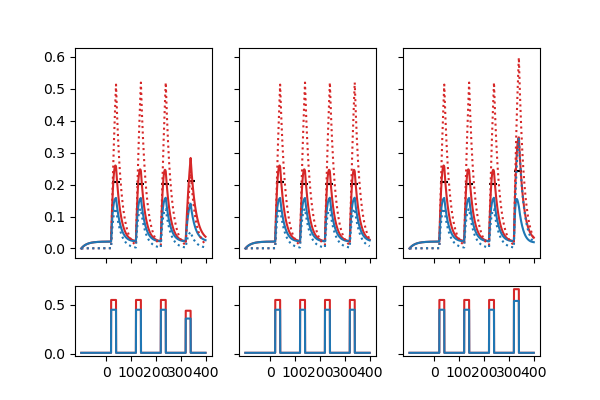

In [5]:
print(sol.x, sol.message)
fig_1 = sim_and_eval_cost(sol.x, plot_sims=True, plot_sims_wo_fb=False)

In [17]:
fig_1.savefig('simple_model_example.pdf')

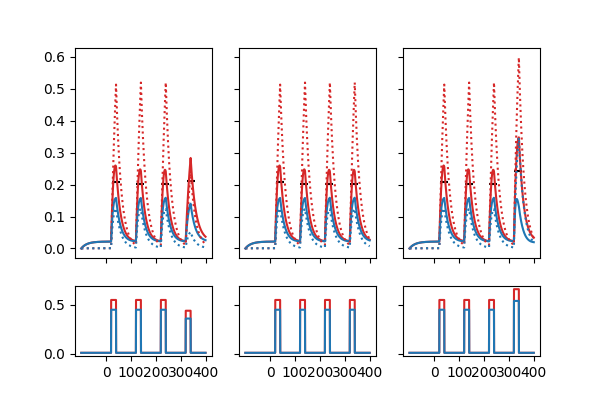

In [68]:
# investigate opt results
x_ = [1., -0.33840608, 0.2270948, -0.2, -1.]  # original
# x_ = [1.4, -0.33840608, 0.2270948, -0.2, -1.]  # diverging
# x_ = [1.0, -0.43840608, 0.2270948, -0.8, -1.]  # converging
fig_1 = sim_and_eval_cost(x_, plot_sims=True, plot_sims_wo_fb=False)
# fig_2 = sim_and_eval_cost(x_, plot_sims=True, plot_sims_wo_fb=True)